In [2]:
"""
PointNet Implementation for Point Cloud Segmentation using PyTorch

For Google Colab: Runtime -> Change runtime type-> Hardware accelerator -> GPU
"""

'\nPointNet Implementation for Point Cloud Segmentation using PyTorch\n\nFor Google Colab: Runtime -> Change runtime type-> Hardware accelerator -> GPU\n'

In [3]:
# import necessary dependencies
import numpy as np
import math
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from path import Path

In [4]:
# utils functions
# add random noise
def add_noise(array):
    noise = np.random.normal(0, 0.02, (array.shape))
    return (array+noise)

# centering & normalization
def cent_norm(array): 
    # centering
    mean = np.mean(array, axis=0)
    verts_centered = array - mean
    # normalization
    max_point_norm = 0
    for row in verts_centered:
        if(np.linalg.norm(row)>max_point_norm):
            max_point_norm = np.linalg.norm(row)
    verts_normalized = verts_centered / max_point_norm
    return verts_normalized

# rotate theta degree around z axis
def rotation_z(arr, theta): # arr -> (num_points, 3)
    theta = theta * math.pi/180
    rot = np.array([[ math.cos(theta), -math.sin(theta), 0],
                    [ math.sin(theta), math.cos(theta), 0],
                    [ 0,               0,               1]])
    arr_rot = rot.dot(arr.transpose()).transpose() # arr_rot -> (num_points, 3)
    return arr_rot

# read .pts (points) and .seg (segmentation labels) files
def read_pts(file):
    verts = np.genfromtxt(file) # verts -> (num_points, 3)
    verts_cent_norm = cent_norm(verts)
    return verts_cent_norm

def read_seg(file):
    seg_labels = np.genfromtxt(file, dtype=(int)) # seg_labels -> (num_points,)
    return seg_labels

def sample_pts_seg(pts, seg, num_sample): # pts -> (num_points, 3), seg -> (num_points,), num_sample -> int
    pts_seg = np.concatenate((pts, np.reshape(seg, (seg.shape[0], 1))), axis=1)
    indices = np.random.choice(pts_seg.shape[0], size=num_sample, replace=False)
    sampled_pts_seg = pts_seg[indices]
    points = sampled_pts_seg[:, 0:3]
    categories = sampled_pts_seg[:, 3]
    return points, categories, indices   

# label to color function
def label2color(seg_labels):
    ''' map segementation labels to colors '''
    map_label_to_color = {
         0: [31, 119, 180],     # Blue
         1: [44, 160, 44],      # Green
         2: [255, 127, 14],     # Orange
         3: [214, 39, 40],      # Red
         4: [255, 187, 120],    # Light Orange
         5: [152, 223, 138],    # Light Green
         6: [174, 199, 232],    # Light Blue
         7: [255, 152, 150],    # Light Red / Salmon
         8: [148, 103, 189],    # Purple
         9: [197, 176, 213],    # Lavender / Light Purple
        10: [140, 86, 75],      # Brown
        11: [196, 156, 148],    # Light Brown / Tan
        12: [227, 119, 194],    # Pink
        13: [247, 182, 209],    # Light Pink / Rose
        14: [127, 127, 127],    # Gray
        15: [199, 199, 199],    # Light Gray
        16: [188, 189, 34],     # Olive / Yellow-Green
        17: [219, 219, 141],    # Light Olive / Khaki
        18: [23, 190, 207],     # Teal / Cyan
        19: [158, 218, 229],    # Light Cyan / Sky Blue
        -1: [255, 255, 255]     # white (ignore)
    }
    colors = np.array([map_label_to_color[label] for label in seg_labels])
    return colors

In [5]:
# dataset
class Data(Dataset):

    def __init__(self, root_dir, valid=False, transform=None):
        self.root_dir = root_dir
        self.files = []
        self.valid = valid

        points_label_dir = root_dir + 'dataset/SegDataset/points_label/'

        for file in os.listdir(points_label_dir):
            img = {}
            img['seg'] = points_label_dir + file # seg_labels
            img['pts'] = root_dir + 'dataset/SegDataset/points/' + file.replace('.seg', '.pts') # points
            self.files.append(img)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        pts_path = self.files[idx]['pts']
        seg_path = self.files[idx]['seg']
        with open(pts_path, 'r') as f:
            points = read_pts(f) # points -> (num_points, 3)
        with open(seg_path, 'r') as f:
            labels = read_seg(f) # labels -> (num_points,)
            labels -= np.ones(labels.shape).astype(int)

        points, labels, indices = sample_pts_seg(points, labels, num_sample=1024)
        
        if not self.valid:
            theta = random.random()*360
            points = rotation_z(add_noise(points), theta)
        
        return {'pts': np.array(points, dtype="float32"), 'seg': labels.astype(int)}

In [6]:
# create dataset
root_dir = './'
dataset = Data(root_dir=root_dir, transform=None)

idx = 1
sample_data = dataset[idx]
pts = sample_data['pts']
seg = sample_data['seg']
print('>>> Shape of points: ', pts.shape)
print('>>> Shape of segs: ', seg.shape)

>>> Shape of points:  (1024, 3)
>>> Shape of segs:  (1024,)


In [108]:
# visualize point cloud
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
pcd.colors = o3d.utility.Vector3dVector(label2color(seg))
o3d.visualization.draw_plotly([pcd])

In [8]:
# create train_loader and valid_loader
train_num = int(len(dataset) * 0.9)
valid_num = len(dataset) - train_num
train_dataset, valid_dataset = random_split(dataset, [train_num, valid_num])
valid_dataset.valid = True

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64)

# test
print('>>> Size of dataset: ', len(dataset))
print('>>> Size of train_dataset: ', len(train_dataset))
print('>>> Size of valid_dataset: ', len(valid_dataset))
print('>>> Size of train_loader: ', len(train_loader))  # Number of batches
print('>>> Size of valid_loader: ', len(valid_loader)) # Number of batches

>>> Size of dataset:  2690
>>> Size of train_dataset:  2421
>>> Size of valid_dataset:  269
>>> Size of train_loader:  38
>>> Size of valid_loader:  5


In [9]:
# tnet
class Tnet(nn.Module):
    """
        The output of the Tnet is the input transform or feature transform, the shape of whichis (batch_size, k, k)
        k = 3 if input transform 
        k = 64 if feature transform
    """

    def __init__(self, k=3): # k = 3 if input transform or k = 64 if feature transform
        super().__init__()

        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input): # input.shape -> (batch_size, k, num_point)

        batch_size = input.size(0)
        num_point = input.size(-1)

        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = F.relu(self.bn3(self.conv3(output))) # output.shape -> (batch_size, 1024, num_point)

        output = nn.MaxPool1d(num_point)(output) # output.shape -> (batch_size, 1024, 1)
        output = nn.Flatten(1)(output) # output.shape -> (batch_size, 1024)

        output = F.relu(self.bn4(self.fc1(output)))
        output = F.relu(self.bn5(self.fc2(output))) 
        output = self.fc3(output) # output.shape -> (batch_size, k*k)

        output = output.view(-1, self.k, self.k) # output.shape -> (batch_size, k, k)
        I = torch.eye(self.k, requires_grad=True).repeat(batch_size, 1, 1) # I.shape -> (batch_size, k, k)
        if output.is_cuda:
            I = I.cuda()
        output = output + I

        return output # output.shape -> (batch_size, k, k)

In [10]:
# transform
class Transform(nn.Module):

    def __init__(self):
        super().__init__()

        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=128)
        self.fc1 = nn.Conv1d(3, 64, 1)
        self.fc2 = nn.Conv1d(64, 128, 1)
        self.fc3 = nn.Conv1d(128, 128, 1)
        self.fc4 = nn.Conv1d(128, 512, 1)
        self.fc5 = nn.Conv1d(512, 2048, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(2048)

    def forward(self, input): # input.shape -> (batch_size, 3, num_point)

        num_point = input.size()[-1]
        matrix_3x3 = self.input_transform(input) # matrix_3x3 -> (batch_size, 3, 3)
        x = torch.bmm(torch.transpose(input, 1, 2), matrix_3x3).transpose(1, 2) # x -> (batch_size, 3, num_point)

        concat_features = [] # features to be concatenated

        output1 = F.relu(self.bn1(self.fc1(x))) # output1 -> (batch_size, 64, num_point)
        concat_features.append(output1)
        output2 = F.relu(self.bn2(self.fc2(output1))) # output2 -> (batch_size, 128, num_point)
        concat_features.append(output2)
        output3 = F.relu(self.bn3(self.fc3(output2))) # output3 -> (batch_size, 128, num_point)
        concat_features.append(output3)
        matrix_128x128 = self.feature_transform(output3) # matrix_128x128 -> (batch_size, 128, 128)

        output4 = torch.bmm(torch.transpose(output3, 1, 2), matrix_128x128).transpose(1, 2) # output4 -> (batch_size, 128, num_point)
        concat_features.append(output4)
        output5 = F.relu(self.bn4(self.fc4(output4))) # output5 -> (batch_size, 512, num_point)
        concat_features.append(output5)
        
        x = self.bn5(self.fc5(output5)) # x -> (batch_size, 2048, num_point)
        x = nn.MaxPool1d(x.size(-1))(x) # x -> (batch_size, 2048, 1)
        x = nn.Flatten(1)(x).repeat(num_point, 1, 1) # x -> (num_point, batch_size, 2048)
        output6 = x.transpose(0, 2).transpose(0, 1) # output6 -> (batch_size, 2048, num_point)
        concat_features.append(output6)

        return concat_features, matrix_3x3, matrix_128x128

In [11]:
# point net segmentation network
class PointNetSeg(nn.Module):

    def __init__(self, classes=10, m=4):
        super().__init__()

        self.transform = Transform()
        self.fc1 = nn.Conv1d(3008, 512, 1)
        self.fc2 = nn.Conv1d(512, 256, 1)
        self.fc3 = nn.Conv1d(256, 128, 1)
        self.fc4 = nn.Conv1d(128, m, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(m)
        self.logsoftmax = nn.LogSoftmax(dim=1) # LogSoftmax + NLLLoss

        
    def forward(self, input): # input.shape -> (batch_size, 3, num_point)
        concat_features, matrix_3x3, matrix_128x128 = self.transform(input)
        concat_x = torch.cat(concat_features, dim=1) # concat_x -> (batch_size, 3008, num_point)
        
        x = F.relu(self.bn1(self.fc1(concat_x))) # x -> (batch_size, 512, num_point)
        x = F.relu(self.bn2(self.fc2(x))) # x -> (batch_size, 256, num_point)
        x = F.relu(self.bn3(self.fc3(x))) # x -> (batch_size, 128, num_point)
        x = F.relu(self.bn4(self.fc4(x))) # x -> (batch_size, m=4, num_point)
        output = self.logsoftmax(x)

        return output, matrix_3x3, matrix_128x128

In [12]:
# test
pointnetseg = PointNetSeg()
input = torch.randn(6, 1024, 3) # batch_size=6, num_point=1024, channels=3
input = input.transpose(1, 2)
output, matrix_3x3, matrix_128x128 = pointnetseg(input)

print('>>> PointNetSeg input size: ', input.size())
print('>>> PointNetSeg output size: ', output.size())
print('>>> Matrix_3x3 size: ', matrix_3x3.size())
print('>>> Matrix_128x128 size: ', matrix_128x128.size())

>>> PointNetSeg input size:  torch.Size([6, 3, 1024])
>>> PointNetSeg output size:  torch.Size([6, 4, 1024])
>>> Matrix_3x3 size:  torch.Size([6, 3, 3])
>>> Matrix_128x128 size:  torch.Size([6, 128, 128])


In [13]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('>>> Device: ', device)

# model
pointnetseg = PointNetSeg().to(device)

# learning rate
learning_rate = 0.001

# optimizer
optimizer = torch.optim.Adam(pointnetseg.parameters(), lr=learning_rate)

>>> Device:  cuda:0


In [14]:
# loss
def pointnetsegloss(outputs, labels, m3x3, m128x128, alpha=0.0001):

    """
             outputs -> (batch_size, categories=4, num_points)
              labels -> (batch_size, num_points)
                m3x3 -> (batch_size, 3, 3)
            m128x128 -> (batch_size, 128, 128)
               alpha -> regularization weight
    """
    
    criterion = torch.nn.NLLLoss() # use Negative Log-Likelihood Loss for multi-class classification
    batch_size = outputs.size(0) # pointnetseg outputs -> (batch_size, categories=4, num_point)

    I3x3 = torch.eye(3, requires_grad=True).repeat(batch_size, 1, 1)
    I128x128 = torch.eye(128, requires_grad=True).repeat(batch_size, 1, 1)

    if outputs.is_cuda:
        I3x3 = I3x3.cuda()
        I128x128 = I128x128.cuda()

    # regularization terms
    Lreg_3x3 = torch.norm(I3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2)))
    Lreg_128x128 = torch.norm(I128x128 - torch.bmm(m128x128, m128x128.transpose(1, 2)))

    # add regularization terms to the training loss
    loss = criterion(outputs, labels) + alpha * (Lreg_3x3 + Lreg_128x128) / float(batch_size)

    return loss

In [15]:
# training loop
def train(model, train_loader, valid_loader=None, epochs=15, save=False):

    training_loss = []
    batch_loss = []
    validation_accuracy = []

    print('>>> ----------- Training loop is starting -----------')

    for epoch in range(epochs):
        pointnetseg.train()
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader):
            """
                      data -> {'pts': pointcloud, 'seg': seg_labels}
                pointcloud -> (batch_size=64, num_point, 3)
                seg_labels -> (batch_size, num_point,)
            """
            inputs = data['pts'].to(device).float()
            labels = data['seg'].to(device).long()

            # send inputs into the model
            outputs, m3x3, m128x128 = pointnetseg(inputs.transpose(1, 2))

            # calculate loss
            loss = pointnetsegloss(outputs, labels, m3x3, m128x128)

            # optimizer update
            optimizer.zero_grad() # zero the gradients
            loss.backward() # backpropagation
            optimizer.step() # update weights

            # print statistics info
            running_loss += loss
            if (i+1) % 10 == 0: # print statistics info every 10 batches

                print('>>> Epoch: %d, Batch: %3d / %3d, loss: %.3f' % (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                batch_loss.append(running_loss / 10)
                running_loss = 0.0

        epoch_time = time.time() - start_time  # calculate time taken for the epoch
        print('>>> Epoch %d training time: %.3f seconds' % (epoch + 1, epoch_time))

        epoch_loss = sum(batch_loss) / len(batch_loss)
        epoch_loss = epoch_loss.cpu().item()
        training_loss.append(epoch_loss)
        batch_loss = []

        # validation
        model.eval()
        correct = total = 0

        if valid_loader:
            with torch.no_grad():
                for data in valid_loader:
                    inputs = data['pts'].to(device).float()
                    labels = data['seg'].to(device)
                    
                    outputs, _, _ = pointnetseg(inputs.transpose(1, 2)) # outputs -> (batch_size, categories=4, num_point)
                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0) * labels.size(1)
                    correct += (predicted == labels).sum().item()

            valid_accuracy = 100. * correct / total
            validation_accuracy.append(valid_accuracy)
            print('>>> Validation accuracy: %d%%' % valid_accuracy)

            if (epoch + 1) != epochs:
                print('>>> -------------------------------------------------')                 

        # save the model
        if save:
            torch.save(model.state_dict(), "save_" + str(epoch) + ".pth")

    print('>>> ----------- Training loop is finished -----------')

    return training_loss, validation_accuracy

In [57]:
# train the network
training_loss, validation_accuracy = train(pointnetseg, train_loader, valid_loader, save=False)

print('>>> Training loss: ', training_loss)
print('>>> Validation accuracy: ', validation_accuracy)

>>> ----------- Training loop is starting -----------
>>> Epoch: 1, Batch:  10 /  38, loss: 1.231
>>> Epoch: 1, Batch:  20 /  38, loss: 1.001
>>> Epoch: 1, Batch:  30 /  38, loss: 0.926
>>> Epoch 1 training time: 543.041 seconds
>>> Validation accuracy: 73%
>>> -------------------------------------------------
>>> Epoch: 2, Batch:  10 /  38, loss: 0.842
>>> Epoch: 2, Batch:  20 /  38, loss: 0.806
>>> Epoch: 2, Batch:  30 /  38, loss: 0.790
>>> Epoch 2 training time: 254.892 seconds
>>> Validation accuracy: 82%
>>> -------------------------------------------------
>>> Epoch: 3, Batch:  10 /  38, loss: 0.749
>>> Epoch: 3, Batch:  20 /  38, loss: 0.737
>>> Epoch: 3, Batch:  30 /  38, loss: 0.717
>>> Epoch 3 training time: 377.924 seconds
>>> Validation accuracy: 83%
>>> -------------------------------------------------
>>> Epoch: 4, Batch:  10 /  38, loss: 0.690
>>> Epoch: 4, Batch:  20 /  38, loss: 0.693
>>> Epoch: 4, Batch:  30 /  38, loss: 0.683
>>> Epoch 4 training time: 322.076 secon

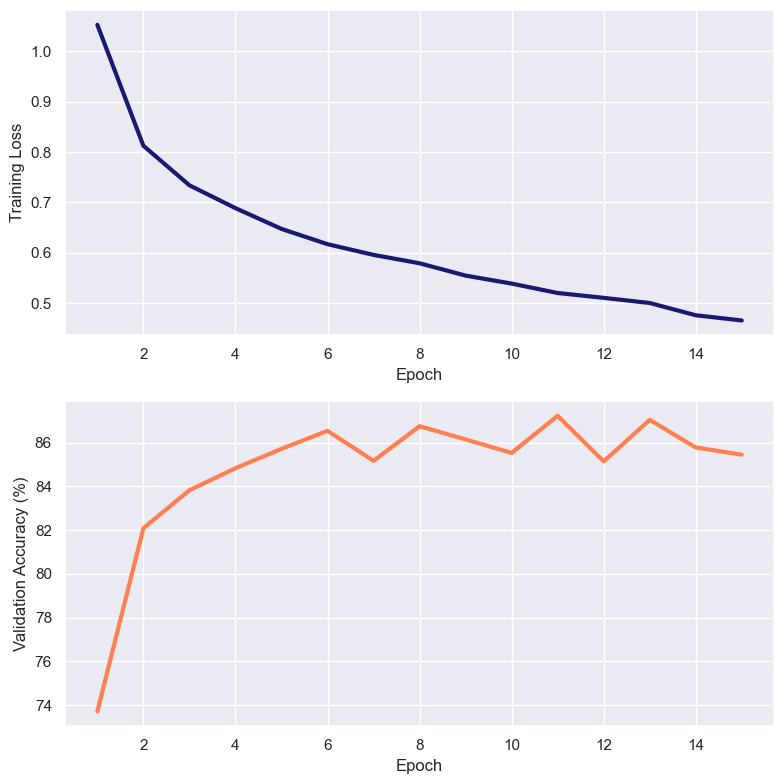

In [59]:
# plot training loss and validation accuracy
epochs = range(1, len(training_loss)+1)
loss = training_loss
accuracy = validation_accuracy

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
sns.set_theme(style='darkgrid')

sns.lineplot(x=epochs, y=loss, linewidth=3, dashes=False, color='midnightblue', ax=axs[0])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')

sns.lineplot(x=epochs, y=accuracy, linewidth=3, dashes=False, color='coral', ax=axs[1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation Accuracy (%)')

# adjust the layout to avoid overlapping
plt.tight_layout()

plt.grid(True)
plt.show()

In [60]:
# save trained model
torch.save(pointnetseg.state_dict(), "pointnet_seg.pth")

In [16]:
# load trained model
pointnetseg = PointNetSeg()
pointnetseg.load_state_dict(torch.load("pointnet_seg.pth"))
pointnetseg.eval()
pointnetseg = pointnetseg.cuda()

C:\Users\Jingxin.Zhang\AppData\Local\Temp\ipykernel_28984\986587348.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [17]:
# test the model
correct = total = 0

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs = data['pts'].to(device).float()
        labels = data['seg'].to(device)
        
        outputs, _, _ = pointnetseg(inputs.transpose(1, 2)) # outputs -> (batch_size, categories=4, num_point)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0) * labels.size(1)
        correct += (predicted == labels).sum().item()

        # print statistics info every batch
        print('>>> Batch: %3d / %3d is done' % (i + 1, len(valid_loader)))

test_accuracy = 100. * correct / total
print('>>> Test accuracy: %d%%' % test_accuracy)
print('>>> ----------- Test is finished -----------')

>>> Batch:   1 /   5 is done
>>> Batch:   2 /   5 is done
>>> Batch:   3 /   5 is done
>>> Batch:   4 /   5 is done
>>> Batch:   5 /   5 is done
>>> Test accuracy: 85%
>>> ----------- Test is finished -----------


In [ ]:
# sample from valid_loader
batch = next(iter(valid_loader)) # get 1st batch
points = batch['pts'].to(device).float()
print('>>> Shape of first batch points in valid_loader: ' + str(points.shape))

# input points into the model
outputs, _, _ = pointnetseg(points.transpose(1, 2))
_, labels = torch.max(outputs.data, 1)
print('>>> Shape of first batch labels in valid_loader: ' + str(labels.shape))

>>> Shape of first batch points in valid_loader: torch.Size([64, 1024, 3])
>>> Shape of first batch labels in valid_loader: torch.Size([64, 1024])


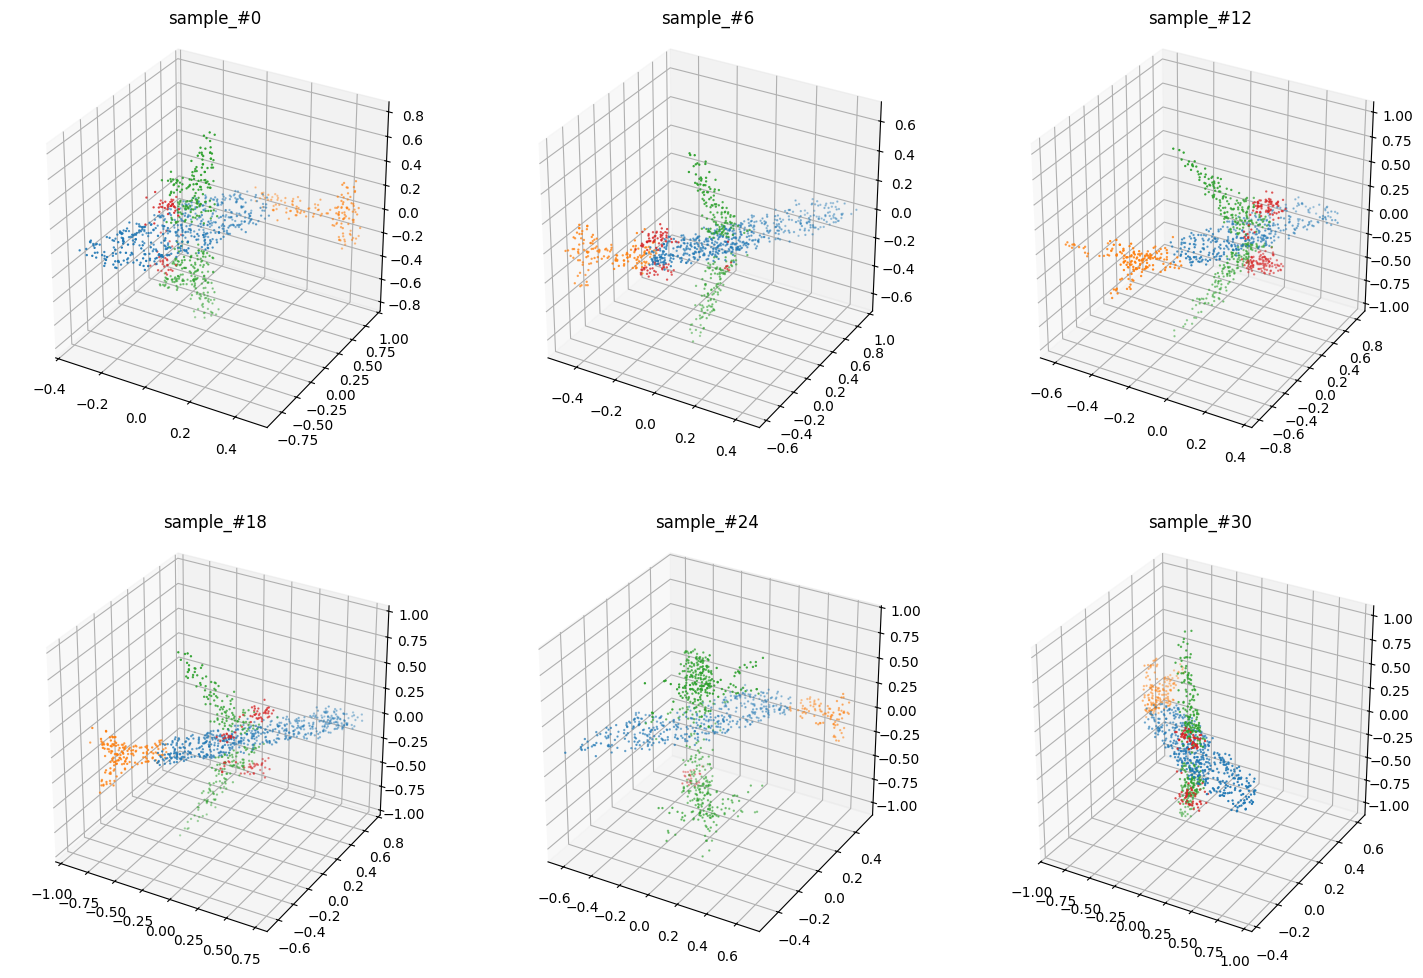

In [107]:
# results visualization
def plot_point_cloud(ax, points, color='b'):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, s=0.5)
    ax.set_box_aspect([1, 1, 1])

num_subplot = 6
fig = plt.figure(figsize=(18, 12))
rows, cols = 2, 3  

for idx in range(num_subplot):
    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    pcd = points[idx * 6].cpu().numpy()
    plot_point_cloud(ax, pcd, color=label2color(labels[idx * 6].cpu().numpy()) / 255)
    ax.set_title(f"sample_#{idx * 6}")

plt.show()

In [106]:
# interactive visualization
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[0].cpu().numpy())
pcd.colors = o3d.utility.Vector3dVector(label2color(labels[0].cpu().numpy()))
o3d.visualization.draw_plotly([pcd])